In [1]:
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

from pkg.utils.utils import *
from pkg.utils.traj_utils import *
import matplotlib.pyplot as plt

from pkg.controller.combined_robot import *
from pkg.project_config import *
rospy.init_node("robot_test")
crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, ((0.3,-0.4,0), (0,0,np.pi/2)),
                INDY_IP),
    RobotConfig(1, RobotType.panda, ((-0.3,-0.4,0), (0,0,np.pi/2)),
                "{}/{}".format(PANDA_REPEATER_IP, PANDA_ROBOT_IP))]
              , connection_list=[False, False])

connection_list
[False, False]


In [2]:
trajectory_list = []
for i_s in range(10):
    trajectory_list.append(np.array(load_json("traj%02d.json"%(i_s))))

In [3]:
crob.grasp_by_dict({'indy0':False, 'panda1': False})

grasp_dict
{'indy0': False, 'panda1': False}
grasp_seq
[('indy0', False), ('panda1', False)]


## TEST TRAJECTORY CALCULATION

In [4]:
TRAJ_FREQ = 50
trajectory = trajectory_list[0]
vel_scale=0.2
acc_scale=0.07
for name, rconfig in zip(crob.robot_names, crob.robots_on_scene):
    _type = rconfig.type
    robot = crob.robot_dict[name]
    traj_cur_rbt = trajectory[:,crob.idx_dict[name]]
    diff_abs_arr = np.abs(traj_cur_rbt - traj_cur_rbt[0:1, :])
    if np.max(diff_abs_arr) > 1e-3:
        dt_step = 1.0/TRAJ_FREQ
        vel_limits = np.multiply(RobotSpecs.get_vel_limits(_type), vel_scale)
        acc_limits = np.multiply(RobotSpecs.get_acc_limits(_type), acc_scale)
        print("vel_limits: {}".format(np.round(vel_limits, 2)))
        print("acc_limits: {}".format(np.round(acc_limits, 2)))
        traj_tot = calc_safe_cubic_traj(dt_step, traj_cur_rbt, vel_limits, acc_limits)
        T_list, Q_list, _ = get_safe_cubics(dt_step, traj_cur_rbt, vel_lim=vel_limits, acc_lim=acc_limits)
        t_all, traj_all = get_traj_all(dt_step, T_list, Q_list)

vel_limits: [0.26 0.26 0.26 0.26 0.31 0.31 0.31]
acc_limits: [0.44 0.44 0.44 0.44 0.44 0.44 0.44]


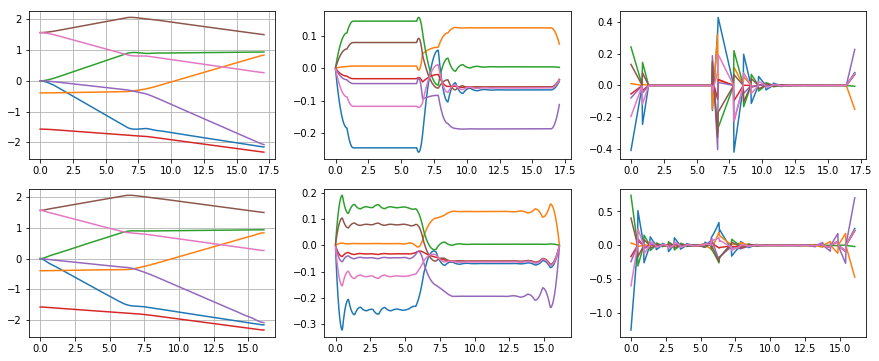

In [7]:
traj_all = np.array(traj_all)

plt.figure(figsize=(15,6))
plt.subplot(2,3,1)
plt.plot(np.arange(len(traj_all)).astype(np.float)*dt_step, traj_all)
# plt.plot(T_accum, Q_list,'x')
plt.grid(True)

plt.subplot(2,3,2)
v_tot = (traj_all[1:]-traj_all[:-1])/dt_step
plt.plot(np.arange(len(v_tot)).astype(np.float)*dt_step, v_tot)

plt.subplot(2,3,3)
a_tot = (v_tot[1:]-v_tot[:-1])/dt_step
plt.plot(np.arange(len(a_tot)).astype(np.float)*dt_step, a_tot)

plt.subplot(2,3,4)
plt.plot(np.arange(len(traj_tot)).astype(np.float)*dt_step, traj_tot)
# plt.plot(T_accum, Q_list,'x')
plt.grid(True)

plt.subplot(2,3,5)
v_tot = (traj_tot[1:]-traj_tot[:-1])/dt_step
plt.plot(np.arange(len(v_tot)).astype(np.float)*dt_step, v_tot)

plt.subplot(2,3,6)
a_tot = (v_tot[1:]-v_tot[:-1])/dt_step
plt.plot(np.arange(len(a_tot)).astype(np.float)*dt_step, a_tot)

In [3]:
# trajectory_list = load_json("traj.json")
# trajectory = np.array(trajectory_list)
# # trajectory = trajectory[:,6:]

## connect robot

In [4]:
crob.reset_connection([True, True])
indy = crob.robot_dict["indy0"]
panda = crob.robot_dict["panda1"]
with indy:
    indy.reset_robot()
    indy.set_joint_vel_level(1)
    indy.set_task_vel_level(1)
crob.grasp_by_dict({"indy0":False, "panda1": False})

connection_list
[True, True]
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
grasp_dict
{'indy0': False, 'panda1': False}
grasp_seq
[('indy0', False), ('panda1', False)]
Connect: Server IP (192.168.0.63)


## WARN: MOVE ROBOT ONCE

In [5]:
crob.joint_make_sure(crob.home_pose)

Connect: Server IP (192.168.0.63)


In [6]:
indy.stop_tracking()

{'stop': True}

In [7]:
vel_scale=0.5
acc_scale=0.5
for trajectory in trajectory_list:
    crob.move_joint_wp(trajectory, vel_scale=vel_scale, acc_scale=acc_scale)
    time.sleep(1)

In [15]:
crob.move_joint_wp(np.array(list(reversed(trajectory))), vel_scale=vel_scale, acc_scale=acc_scale)
time.sleep(1)

## WARN: MOVE ROBOT ALL TRAJ

In [26]:
crob.joint_make_sure(crob.home_pose)

Connect: Server IP (192.168.0.63)


In [15]:
indy.stop_tracking()

{'stop': True}

In [14]:
vel_scale=0.3
acc_scale=0.05
for trajectory in trajectory_list:
    crob.move_joint_wp(trajectory, vel_scale=vel_scale, acc_scale=acc_scale)
    time.sleep(1)